# Task
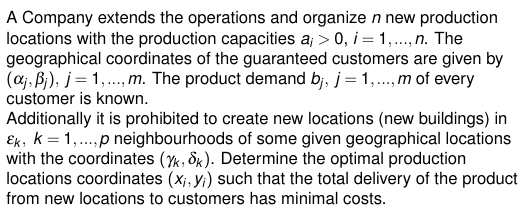

# Formalization

Everything is given except of $a_{ij}$ which need to be found at the end of optimization process.
**Assumption 1**: $a_{ij}$ may be non-integer, i.e. the Company delivers e.g. some amount of sugar and not indivisible packets of sugar.
**Assumption 2**: delivery cost depends on amount of product transfered and distance, i.e. $\text{distance} \times \text{amount}$
$$
\begin{aligned}
&\min a_{ij}\sqrt{(x_i-\alpha_j)^2 + (y_i - \beta_j)^2}\\
&\text{s.t.} \quad\\
&\sum_j{a_{ij}} \leq a_i\\
&\sum_i{a_{ij}} = b_j\\
&(\gamma_k - x_i)^2 + (\delta_k - y_i)^2 > \epsilon_k^2 \\
&a_{ij} \geq 0\\
\end{aligned}
$$
 

# Solution
Let's solve for a simple case with number of production locations $n=4$

In [1]:
import gurobipy as gp
import numpy as np

In [55]:
def helper_gen(a, customers):
    for i in range(len(a)):
        for j in range(len(customers)):
            yield i,j
            
def get_var(model, var_name):
#     [print(var.X) for var in model.getVars() if var_name in var.VarName]
    return [var.X for var in model.getVars() if var_name in var.VarName]

In [77]:
def solve(a, customers, neighborhoods):
    m = gp.Model('test')
    m.params.NonConvex = 2
    m.setParam('NonConvex', 2)
    x = m.addVars(list(range(len(a))), name='x')
    y = m.addVars(list(range(len(a))), name='y')
    small_as = m.addVars(helper_gen(a, customers), name='as')
    small_as_sq = m.addVars(helper_gen(a, customers), name='as_sq')
    m.addConstrs(small_as_sq[i, j] == small_as[i, j]**2 for i,j in helper_gen(a, customers))

    dists = m.addVars(helper_gen(a, customers), name='dists')

    m.addConstrs((x[i] - customers[j][0])**2 + (y[i] - customers[j][1])**2 == dists[i,j] for i, j in helper_gen(a, customers))

    m.addConstrs(small_as.sum(j, '*') <= a[j] for j in range(len(a)))
    m.addConstrs(small_as.sum('*', i) == customers[i][2] for i in range(len(customers)))
    m.addConstrs(small_as[i,j] >= 0 for i,j in helper_gen(a, customers))

    neigh_dists = m.addVars(helper_gen(a, customers), name='neigh_dists')
    m.addConstrs((x[i] - neighborhoods[j][0])**2 + (y[i] - neighborhoods[j][1])**2 >= neighborhoods[j][2]
                 for i in range(len(a)) for j in range(len(neighborhoods)))



    m.setObjective(small_as_sq.prod(dists), sense=gp.GRB.MINIMIZE)
    m.write('test.lp')
    m.optimize()
    
    return m.objVal, list(zip(get_var(m, 'x'), get_var(m, 'y'))), m

Let's check that it works for simple cases:

Here we have two clients with the same demand and no prohibited neighborhoods. Therefore, production location should stand right in between the two.

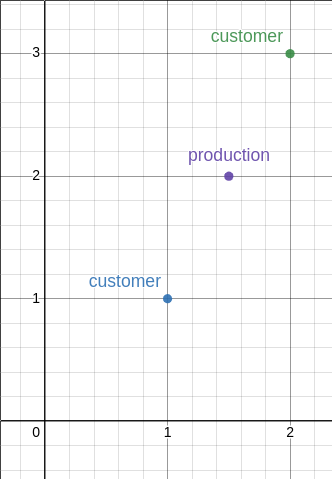

In [78]:
a = np.array([10])
customers = np.array([[1,1,4],[2,3,4]])
neighborhoods = np.array([])

solve(a, customers, neighborhoods)[:-1]

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 10 columns and 6 nonzeros
Model fingerprint: 0x8872a658
Model has 2 quadratic objective terms
Model has 4 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 6e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+01]
  QRHS range       [2e+00, 1e+01]
Presolve removed 5 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 4 rows and 6 columns
Presolve time: 0.00s
Presolved: 8 rows, 7 columns, 19 nonzeros
Presolved model has 2 bilinear constraint(s)
Variable types: 7 continuous, 0 integer (0 binary)


(40.000000000000014, [(1.500000000010415, 2.000000000007811)])

If I say that one client has a higher demand than the other, the production location should shift closer to the client with a higher demand.

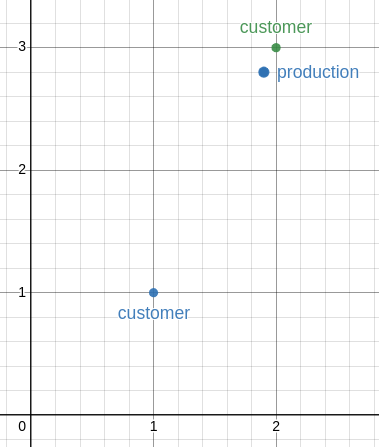

In [79]:
a = np.array([10])
customers = np.array([[1,1,2],[2,3,6]])
neighborhoods = np.array([])

solve(a, customers, neighborhoods)[:-1]

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 10 columns and 6 nonzeros
Model fingerprint: 0xcdb746bd
Model has 2 quadratic objective terms
Model has 4 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 6e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
  QRHS range       [2e+00, 1e+01]
Presolve removed 5 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 4 rows and 6 columns
Presolve time: 0.00s
Presolved: 8 rows, 7 columns, 19 nonzeros
Presolved model has 2 bilinear constraint(s)
Variable types: 7 continuous, 0 integer (0 binary)


(17.999999999999993, [(1.8999999999621306, 2.799999999915569)])

Now I allow to set two production locations. If I have two clients, then productions location should get closest to those clients - at the same locations.

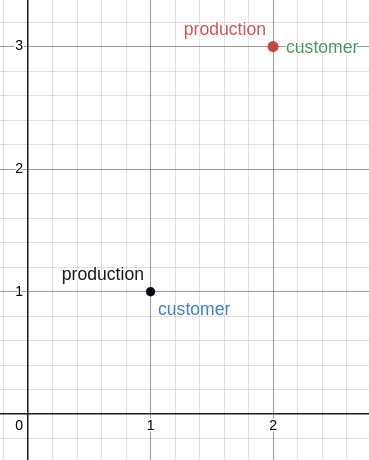

In [80]:
a = np.array([10, 10])
customers = np.array([[1,1,4],[2,3,4]])
neighborhoods = np.array([])

solve(a, customers, neighborhoods)[:-1]

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 20 columns and 12 nonzeros
Model fingerprint: 0x9606afea
Model has 4 quadratic objective terms
Model has 8 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 6e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+01]
  QRHS range       [2e+00, 1e+01]
Presolve removed 6 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 4 rows and 4 columns
Presolve time: 0.00s
Presolved: 39 rows, 26 columns, 79 nonzeros
Presolved model has 12 bilinear constraint(s)
Variable types: 26 continuous, 0 integer (0 bin

(6.9996840487275555e-09,
 [(1.9999983522100893, 2.999985753293061),
  (1.0000084349522287, 1.0000115988559841)])

Now what if I want to prohibit such behaviour? I set non-zero neighborhoods around clients. Though in this case it seems that there is no unique solution - locations can stay at any point on the neighborhood circle. Still, gurobi succeeds in solving that task.

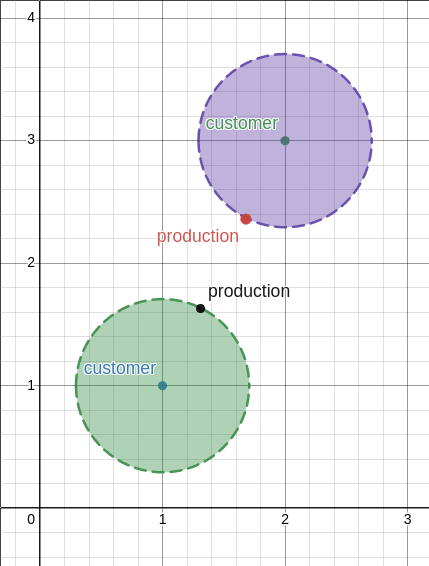

In [81]:
a = np.array([10, 10])
customers = np.array([[1,1,4],[2,3,4]])
neighborhoods = np.array([[1,1,0.5], [2,3,0.5]])

solve(a, customers, neighborhoods)[:-1]

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 20 columns and 12 nonzeros
Model fingerprint: 0x736eaf2f
Model has 4 quadratic objective terms
Model has 12 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 6e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+01]
  QRHS range       [2e+00, 1e+01]
Presolve removed 6 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 4 rows and 4 columns
Presolve time: 0.00s
Presolved: 39 rows, 26 columns, 83 nonzeros
Presolved model has 12 bilinear constraint(s)
Variable types: 26 continuous, 0 integer (0 bi

(13.180837418276433,
 [(1.3155016621817275, 1.6328183405953944),
  (1.6832818894002102, 2.367788757965839)])

Remember the case with single production location and two clients with unequal demands? What if I add a neighborhood around the greedy one? It stays on the border as it should.

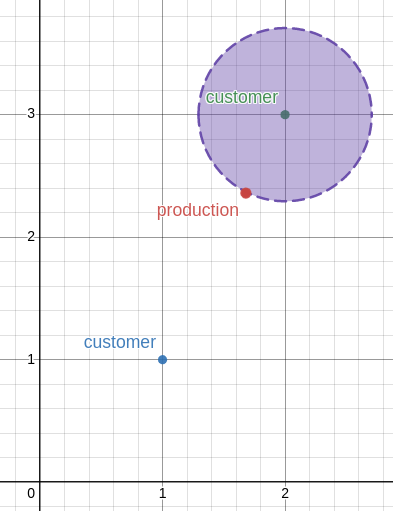

In [90]:
a = np.array([10])
customers = np.array([[1,1,2],[2,3,6]])
neighborhoods = np.array([[2,3,0.5]])

solve(a, customers, neighborhoods)[:-1]

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 10 columns and 6 nonzeros
Model fingerprint: 0xd8956272
Model has 2 quadratic objective terms
Model has 5 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 6e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
  QRHS range       [2e+00, 1e+01]
Presolve removed 5 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 4 rows and 6 columns
Presolve time: 0.00s
Presolved: 8 rows, 7 columns, 19 nonzeros
Presolved model has 2 bilinear constraint(s)
Variable types: 7 continuous, 0 integer (0 binary)


(27.35088936098108, [(1.6837722339840515, 2.3675444679180537)])

Now, what if I have one greedy client and a lot of small prodution locations?

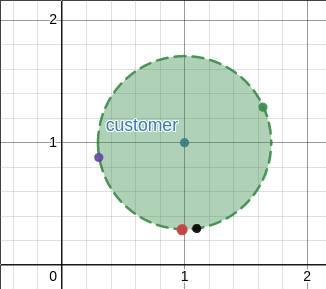

In [86]:
a = np.array([1,1,1,1])
customers = np.array([[1,1,3]])
neighborhoods = np.array([[1,1,0.5]])

obj_val, coords, m = solve(a, customers, neighborhoods)
coords

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9 rows, 24 columns and 12 nonzeros
Model fingerprint: 0x817f4a8d
Model has 4 quadratic objective terms
Model has 12 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
  QRHS range       [2e+00, 2e+00]
Presolve removed 8 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 8 rows and 4 columns
Presolve time: 0.00s
Presolved: 50 rows, 34 columns, 105 nonzeros
Presolved model has 16 bilinear constraint(s)
Variable types: 34 continuous, 0 integer (0 b

[(1.6418154576117212, 1.29677136124715),
 (0.3019653386115252, 0.887094589293866),
 (1.1093052521998341, 0.3013929886049453),
 (0.9832722756549811, 0.29309174241149244)]

Notice that though only $3$ production locations are enough, all $4$ of them will be near the customer. Gurobi assigns non-zero values to all $a_{ij}$. That could be solved by, for example, $L1$ penalty on $a_{ij}$ values.

In [87]:
for v in m.getVars():
    if (abs(v.x) > 1e-6):
        print(v.varName, v.x)

x[0] 1.6418154576117212
x[1] 0.3019653386115252
x[2] 1.1093052521998341
x[3] 0.9832722756549811
y[0] 1.29677136124715
y[1] 0.887094589293866
y[2] 0.3013929886049453
y[3] 0.29309174241149244
as[0,0] 0.7504595236961997
as[1,0] 0.7495404758788
as[2,0] 0.7500000002125
as[3,0] 0.7500000002125
as_sq[0,0] 0.5631889795485621
as_sq[1,0] 0.5618107138180047
as_sq[2,0] 0.56250000031875
as_sq[3,0] 0.56250000031875
dists[0,0] 0.5
dists[1,0] 0.5
dists[2,0] 0.5
dists[3,0] 0.5


Another cases:

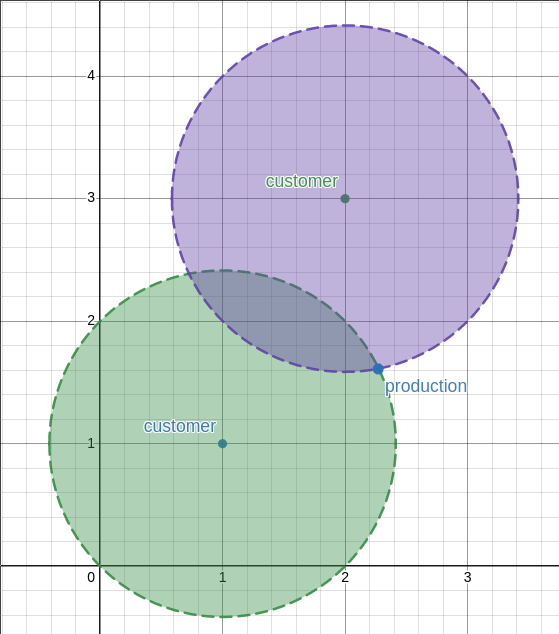

In [75]:
a = np.array([10])
customers = np.array([[1,1,2],[2,3,6]])
neighborhoods = np.array([[2,3,2], [1,1,2]])

solve(a, customers, neighborhoods)

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 10 columns and 6 nonzeros
Model fingerprint: 0xf785b8fd
Model has 2 quadratic objective terms
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 6e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
  QRHS range       [2e+00, 1e+01]
Presolve removed 5 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 4 rows and 6 columns
Presolve time: 0.00s
Presolved: 8 rows, 7 columns, 19 nonzeros
Presolved model has 2 bilinear constraint(s)
Variable types: 7 continuous, 0 integer (0 binary)


(80.00000000332223, [(2.2745966693975377, 1.6127016653935138)])